In [1]:
from dotenv import load_dotenv
import os
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from langchain_ollama import OllamaEmbeddings
#from langchain_openai import ChatOpenAI
#from langchain_openai import OpenAIEmbeddings

load_dotenv()

True

In [2]:
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
VECTOR_DB_ROUTE = os.getenv('VECTOR_DB_ROUTE')    
LLM = ChatGroq(
    model=os.getenv('LLM_MODEL'),
    temperature=float(os.getenv('LLM_TEMPERATURE')),
)
EMBEDDING_FUNCTION = OllamaEmbeddings(model=os.getenv('EMBEDDING_MODEL', 'mistral-nemo'))

In [3]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma

embedding_function = EMBEDDING_FUNCTION
persist_directory = VECTOR_DB_ROUTE

db = Chroma(persist_directory=persist_directory, embedding_function=embedding_function)

retriever = db.as_retriever()

C:\Users\aj0505\AppData\Local\Temp\ipykernel_19096\2882589806.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(persist_directory=persist_directory, embedding_function=embedding_function)


In [4]:
from typing import List, Optional
from typing_extensions import TypedDict

from agent_state import AgentState

In [5]:
def retrieve_docs(state: AgentState):
    question = state["question"]
    documents = retriever.get_relevant_documents(query=question)
    print("RETRIEVED DOCUMENTS:", documents)
    state["documents"] = [doc.page_content for doc in documents]
    return state

In [6]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from grade_question import GradeQuestion

def question_classifier(state: AgentState):
    question = state["question"]

    system = """You are a classifier for user questions. Please categorize the question based on its topic.\n
        Choose one of the following categories:
        1. Sonnen-Apotheke_Info: Questions about Sonnen-Apotheke, such as:
            - Information about the owner or manager (e.g., Dr. Marie Schmidt)
            - Pricing of medications and health products
            - Opening hours and emergency services
            - Services like consultations, measurements, delivery options
            - Health events or informational sessions
            - Multilingual services
        2. Medical_Question: General health or medication-related questions that are not specific to Sonnen-Apotheke.
        3. General_Knowledge: General knowledge questions unrelated to health or pharmacy services.
        4. Unrelated: Questions on completely unrelated topics.

        Examples:
          - How late is the pharmacy open? -> Sonnen-Apotheke_Info
          - What is the use of ibuprofen? -> Medical_Question
          - What's the capital of France? -> General_Knowledge
          - Is a free time slot available -> Appointment

        Respond with one of the categories: 'Sonnen-Apotheke_Info', 'Medical_Question', 'General_Knowledge', or 'Appointment'.
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = LLM
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print(f"QUESTION and CATEGORY: {question} - {result.score}")
    state["category"] = result.score
    return state

In [7]:
def on_topic_router(state: AgentState):
    category = state["category"]  # Assuming 'category' is the new field storing classification output

    # Define routes for each expected category
    if category == "Sonnen-Apotheke_Info":
        return "on_topic"
    elif category == "Medical_Question":
        return "medical"
    elif category == "General_Knowledge":
        return "route_general_knowledge"
    elif category == "Appointment":
        return "appointment"

In [8]:
def general_knowledge_response(state: AgentState):
    """Handles responses for questions categorized as General Knowledge."""
    state["llm_output"] = "Ich bin auf die Apotheke spezialisiert und kann allgemeine Wissensfragen nicht beantworten."
    return state

In [11]:
from langchain_community.graphs import Neo4jGraph

NEO4J_URI = os.getenv('NEO4J_URI')            
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME') 
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')  
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') 

graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

In [12]:
from langchain.chains import GraphCypherQAChain

def medical_question_response(state: AgentState):
    llm = LLM
    question = state["question"]

    # Assuming `graph` is your graph database connection
    chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, allow_dangerous_requests=True, verbose=True)

    # Invoke the chain with the question
    result = chain.invoke({"query": question})
    state["llm_output"] = result
    return state

In [13]:
from grade_documents import GradeDocuments

def document_grader(state: AgentState):
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = LLM
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [14]:
def gen_router(state: AgentState):
    grades = state["grades"]
    print("DOCUMENT GRADES:", grades)

    if any(grade.lower() == "yes" for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("FILTERED DOCUMENT GRADES:", filtered_grades)
        return "generate"
    else:
        return "rewrite_query"

In [ ]:
from langchain_core.output_parsers import StrOutputParser

def rewriter(state: AgentState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = LLM
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser


def generate_answer(state: AgentState):
    llm = LLM
    question = state["question"]
    context = state["documents"]

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})
    state["llm_output"] = result
    return state

In [25]:
class Ledger:
    def __init__(self):
        self.entries = []

    def add_entry(self, entry):
        self.entries.append(entry)

    def get_entries(self):
        return self.entries


In [ ]:
from langgraph.graph import StateGraph, END

# Ledger-Instanz erstellen
ledger = Ledger()

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
#workflow.add_node("appointment_response", appointment_response)
workflow.add_node("general_knowledge_response", general_knowledge_response)
workflow.add_node("medical_question_response", medical_question_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

#workflow.add_edge("appointment_response", END)
workflow.add_edge("general_knowledge_response", END)
workflow.add_edge("medical_question_response", END)
workflow.add_edge("retrieve_docs", "document_grader")

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
#        "appointment": "appointment_response",
        "general": "general_knowledge_response",
        "medical": "medical_question_response"
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()

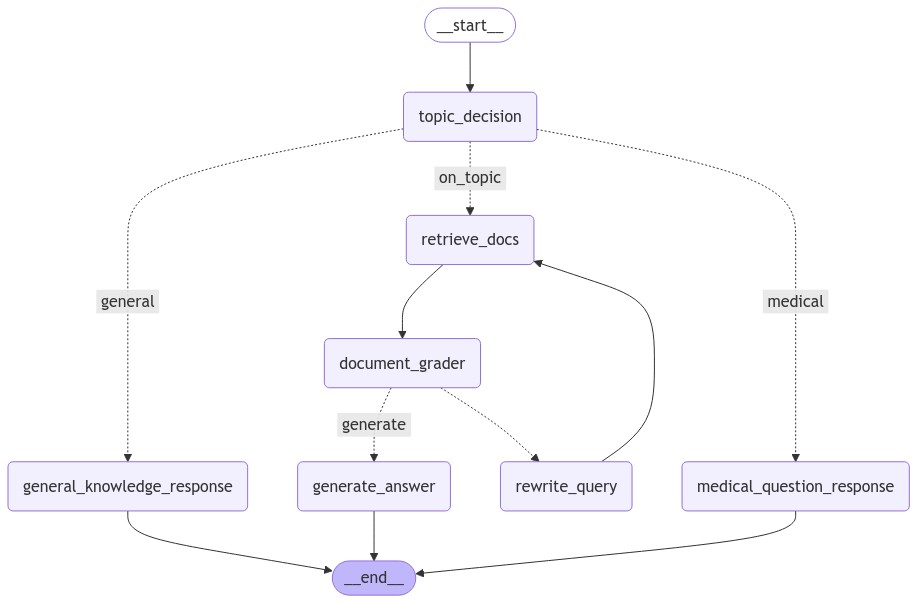

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
result = app.invoke({"question": "Was sind die Öffnungszeiten der Sonnen-Apotheke?"})
result["llm_output"]

In [19]:
result = app.invoke({"question": "Gibt es Patienten welche ein Symptom teilen? Wenn ja welches bitte"})
result["llm_output"]

QUESTION and CATEGORY: Gibt es Patienten welche ein Symptom teilen? Wenn ja welches bitte - Medical_Question


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p1:Person)-[:HAT_SYMPTOM]->(s:Symptom)<-[:HAT_SYMPTOM]-(p2:Person) 
WHERE p1.id <> p2.id 
RETURN DISTINCT s.name
Full Context:
[{'s.name': 'Fieber'}, {'s.name': 'Unwohlsein'}]

> Finished chain.


{'query': 'Gibt es Patienten welche ein Symptom teilen? Wenn ja welches bitte',
 'result': 'Ja, es gibt Patienten, die ein Symptom teilen. Die Symptome sind Fieber und Unwohlsein.'}

In [21]:
import gradio as gr

def process_question(question):
    # Rufen Sie die app mit der Frage auf
    result = app.invoke({"question": question})
    
    # Extrahieren Sie llm_output aus dem Ergebnis
    llm_output = result.get("llm_output", "Keine Ausgabe generiert")
    
    return llm_output

# Erstellen der Gradio-Oberfläche mit dunklem Thema
iface = gr.Interface(
    fn=process_question,
    inputs=gr.Textbox(lines=2, placeholder="Geben Sie Ihre Frage hier ein...", label="Frage"),
    outputs=gr.Textbox(label="Antwort"),
    title="Wissensgrafen-Abfrageoberfläche",
    description="Stellen Sie eine Frage zu den Informationen im Wissensgraphen.",
    examples=[
        ["Was sind die Öffnungszeiten der Sonnen-Apotheke?"],
        ["Welche Dienstleistungen bietet die Sonnen-Apotheke an?"]
    ],
    theme="dark"  # Setzen des Themas auf dunkel
)

# Starten der Oberfläche
iface.launch()


C:\Users\aj0505\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\blocks.py:982: UserWarning: Cannot load dark. Caught Exception: module 'huggingface_hub.utils' has no attribute '_errors'
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
